In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import torch.nn as nn
import wandb
from pysnic.algorithms.snic import snic
from skimage.segmentation import mark_boundaries
from torch.autograd import Variable
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Accuracy, F1Score

from model.cnn_classifier import model_4D
from utils.data_modules import SaveFeatures


class Pseudomasks():
    def __init__(self, test_loader, cam_threshold, overlap_threshold,
                 snic_seeds, snic_compactness, finetuned, std_from_mean):

        self.test_loader = test_loader
        self.cam_threshold = cam_threshold
        self.std_from_mean = std_from_mean
        self.overlap_threshold= overlap_threshold
        self.snic_seeds = snic_seeds
        self.snic_compactness = snic_compactness
        self.finetuned = finetuned
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def init_model(self):
        model = model_4D()
        if self.finetuned:
            model.classifier = nn.Sequential(
                nn.Conv2d(2, 2, kernel_size=3, padding=1),
                nn.BatchNorm2d(2),
                nn.ReLU(inplace=True),
                nn.Conv2d(2, 2, kernel_size=3, padding=1))
        model.to(self.device)
        return model

    def model_from_artifact(self, artifact_path = 'nadjaflechner/VGG_CAMs/finetuned_model:V3829'):
        # if loading the model from a wandb artifact

        run = wandb.init(project= 'VGG_CAMs')
        artifact = run.use_artifact(artifact_path, type='model')
        artifact_dir = artifact.download()
        # state_dict = torch.load(f"{artifact_dir}/model.pth")
        # TODO: REMOVE LINE BELOW (FOR RUNNING ON MY MACBOOK)
        state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
        model = self.init_model()
        model.load_state_dict(state_dict)
        model.eval()
        self.model = model

    def model_from_dict(self, state_dict):
        # if loading the model from a wandb artifact
        model = self.init_model()
        model.load_state_dict(state_dict)
        model.eval()
        self.model = model

    def test_loop(self, test_loader):

        running_jaccard = 0
        running_accuracy = 0
        running_F1 = 0

        for im, lab, _, gt_mask in test_loader:
            pseudomask = self.generate_mask(im, gt_mask, save_plot=False) # TODO make saveplot true sometimes
            # calculate metrics to evaluate model on test set
            generated_mask = torch.Tensor(pseudomask).int().view(400,400).to(self.device)
            groundtruth_mask = torch.Tensor(gt_mask).int().view(400,400).to(self.device)
            jaccard, accuracy, F1 = self.calc_metrics(generated_mask, groundtruth_mask)
            running_jaccard += jaccard
            running_accuracy += accuracy
            running_F1 += F1

        wandb.log({"test_mean_jaccard": running_jaccard / len(test_loader.dataset)})
        wandb.log({"test_mean_accuracy": running_accuracy / len(test_loader.dataset)})
        wandb.log({"test_mean_F1": running_F1 / len(test_loader.dataset)})

    def generate_mask(self, im, gt, save_plot: bool):

        #get the last convolution
        if not self.finetuned:
            sf = SaveFeatures(self.model.features[-4])
        else: sf = SaveFeatures(self.model.classifier[-1])
        im = Variable(im).to(self.device)
        outputs = self.model(im).to(self.device)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach()#.numpy()

        pals_acts = torch.nn.functional.interpolate(
            input = arr[:,1,:,:].unsqueeze(1),
            scale_factor = im.shape[3]/arr.shape[3],
            mode='bilinear'
        ).cpu().detach()
        
        # select pixels based on activation threshold
        # if we include an image-specific threshold 
        if self.std_from_mean: 
            im_based_act_threshold = pals_acts.view(-1).mean() + self.std_from_mean * torch.std(pals_acts, dim=None)
            max_thresh = max([self.cam_threshold, im_based_act_threshold])
            pixels_activated = torch.where(torch.Tensor(pals_acts) > max_thresh, 1, 0).squeeze(0).permute(1,2,0).numpy()
         # if we use the global threshold 
        else:
            pixels_activated = torch.where(torch.Tensor(pals_acts) > self.cam_threshold, 1, 0).squeeze(0).permute(1,2,0).numpy()

        print(f"maximum activation = {torch.max(pals_acts)}") #TODO remove this line

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()
        superpixels = np.array(snic(cpu_img, int(self.snic_seeds), self.snic_compactness)[0])
        pseudomask = self.create_superpixel_mask(superpixels, pixels_activated.squeeze(), threshold=self.overlap_threshold)

        if save_plot: self.generate_plot(cpu_img, pals_acts, im, pixels_activated, superpixels, pseudomask, gt)
        
        return cpu_img, pals_acts, im, pixels_activated, superpixels, pseudomask, gt

    def generate_plot(self, cpu_img, pals_acts, im, pixels_activated, superpixels, pseudomask, gt):

        # Plotting fucntion to visualize the pseudomask generation process (and intermediates)
        cmap = mcolors.ListedColormap(['black', 'lightblue'])
        bounds = [0, 0.5, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize = (30,6))

        ax1.imshow(cpu_img[:,:,:3])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title('original image')

        ax2.imshow(cpu_img[:,:,:3])
        ax2.imshow(pals_acts.view(im.shape[3], im.shape[3], 1), alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('CAM')

        ax3.imshow(pixels_activated, cmap=cmap, norm=norm)
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('Activated cells')

        ax4.imshow(mark_boundaries(cpu_img[:,:,:3], superpixels)) # TODO change so image is actually plotted.
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.set_title('Superpixels')

        ax5.imshow(pseudomask, cmap=cmap, norm=norm)
        ax5.set_xticks([])
        ax5.set_yticks([])
        ax5.set_title('Pseudomask')

        ax6.imshow(gt.squeeze(0).permute(1,2,0).long().numpy(), cmap=cmap, norm=norm)
        ax6.set_xticks([])
        ax6.set_yticks([])
        ax6.set_title('Ground Truth')

        plt.tight_layout()
        plt.show()

        # TODO: restore original block below (remove above)
        # plt.tight_layout()
        # wandb.log({'pseudomask': fig})
        # plt.close()

    def calc_metrics(self, pseudomask, gt):
        # Jaccard index (aka Intersection over Union - IoU) is the most common semantic seg metric
        jaccard = MulticlassJaccardIndex(num_classes=2).to(self.device)
        accuracy = Accuracy(task="multiclass", num_classes=2).to(self.device)
        F1 = F1Score(task="multiclass", num_classes=2).to(self.device)

        return jaccard(pseudomask, gt), accuracy(pseudomask, gt), F1(pseudomask, gt)

    def create_superpixel_mask(self, superpixels, binary_mask, threshold):
        # Get the unique superpixel labels
        unique_labels = np.unique(superpixels)

        # Create a dictionary to store the overlap percentage for each superpixel
        overlap_dict = {}

        # Iterate over each superpixel
        for label in unique_labels:
            # Create a mask for the current superpixel
            superpixel_mask = (superpixels == label)

            # Calculate the overlap percentage between activated and superpixel
            superpixel_size = np.sum(superpixel_mask)
            overlap_count = np.sum(superpixel_mask & binary_mask)
            overlap_percentage = overlap_count / superpixel_size

            # Store the overlap percentage in the dictionary
            overlap_dict[label] = overlap_percentage

        # Create a new binary mask based on the overlap threshold
        new_binary_mask = np.zeros_like(binary_mask, dtype=bool)

        # Iterate over each superpixel again
        for label in unique_labels:
            # Check if the overlap percentage is greater than the threshold
            if overlap_dict[label] > threshold:
                # Set the pixels belonging to the superpixel to 1 in the new binary mask
                new_binary_mask[superpixels == label] = 1

        return new_binary_mask


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
############
# Imports #
############

import json
import os

import torch
import wandb
from torch.utils.data import DataLoader

from model.cnn_classifier import model_4D
from model.finetune import FinetuneLoop
# from model.pseudomask import Pseudomasks
from model.train import ClassifierTrainLoop
from utils.data_modules import ImageDataset, TestSet, filter_dataset

# Hardcode configs: 

artifact_path = 'nadjaflechner/VGG_CAMs/classification_model:v62'

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/FINALFINAL_200m_groundtruths'
depth_layer = 'hs'
normalize = True
finetune = False

cam_threshold_factor = 0.95
overlap_threshold = 0.3
snic_seeds = 100
snic_compactness = 10
std_from_mean = 2

##################
# evaluate model #
##################

print('Testing model ...')
test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

pseudomask_generator = Pseudomasks(test_loader, cam_threshold_factor, overlap_threshold,
                                    snic_seeds, snic_compactness, finetune, std_from_mean)
pseudomask_generator.model_from_artifact(artifact_path)

Testing model ...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


maximum activation = 4.202744007110596


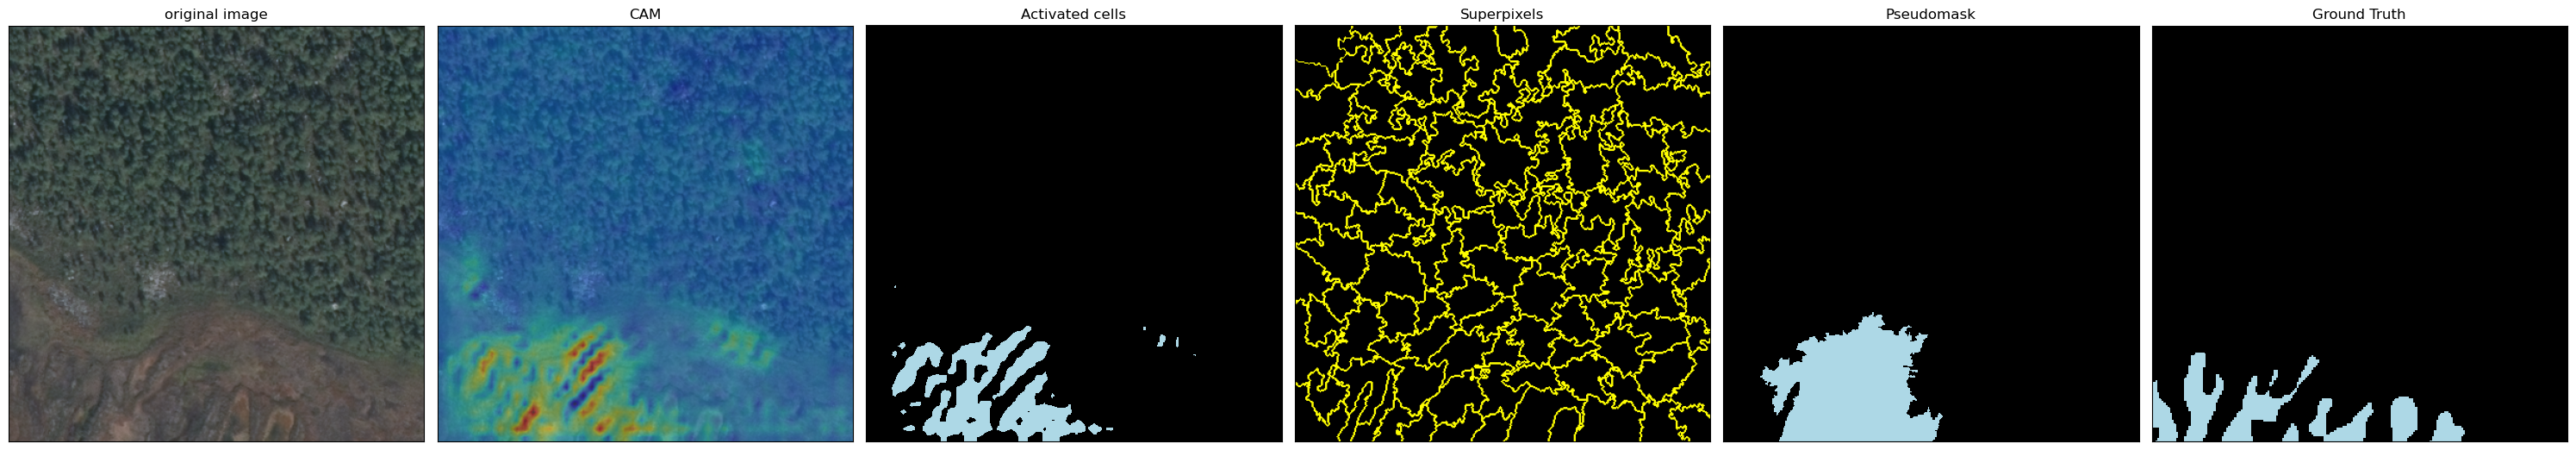

In [3]:
for im, lab, perc_label, gt_mask in test_loader: 
    if lab != 0: 
        cpu_img, pals_acts, im, pixels_activated, superpixels, pseudomask, gt = pseudomask_generator.generate_mask(im, gt_mask, save_plot=True)
    break

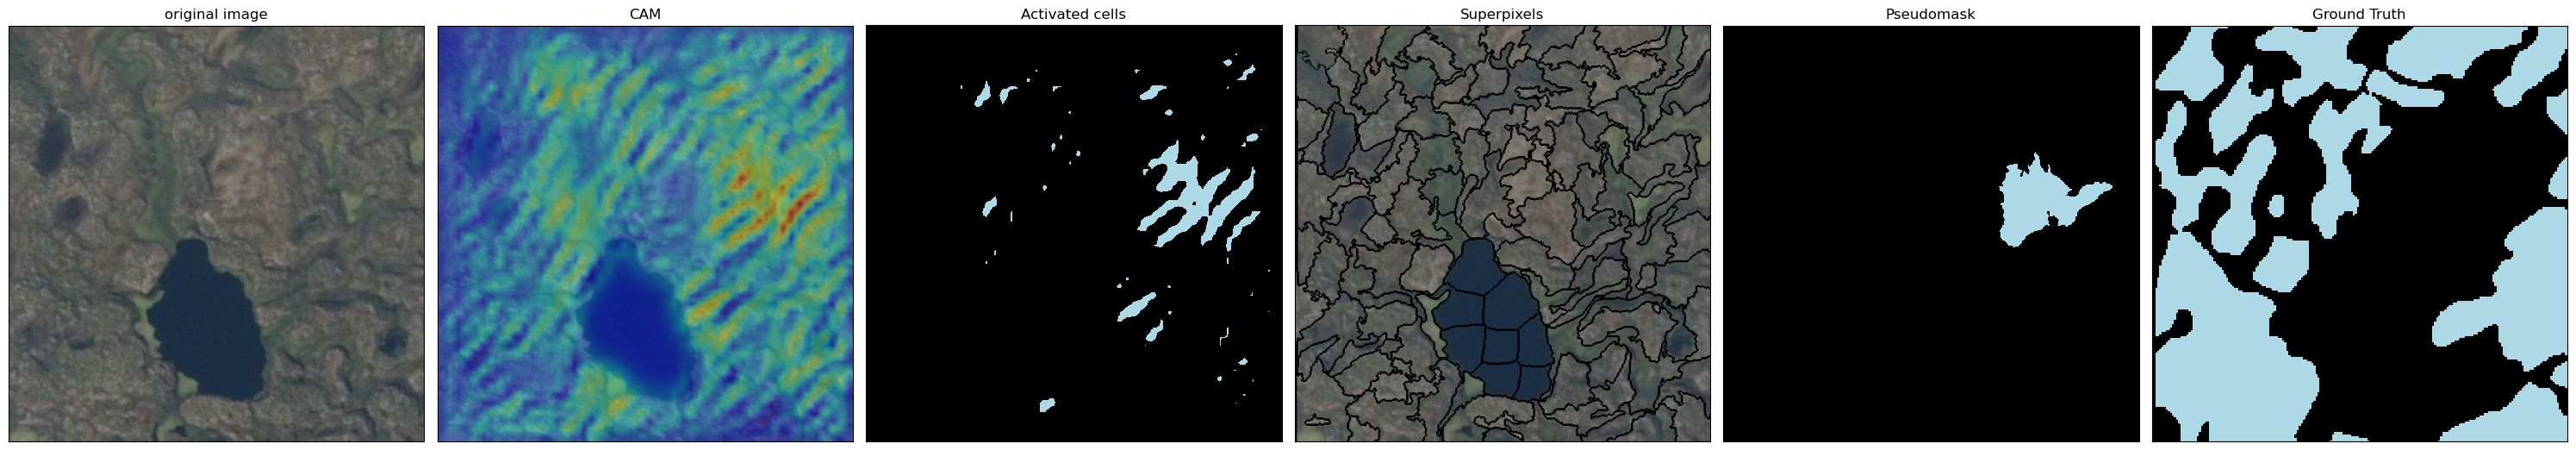

In [6]:
# Plotting fucntion to visualize the pseudomask generation process (and intermediates)
cmap = mcolors.ListedColormap(['black', 'lightblue'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize = (30,6))

ax1.imshow(cpu_img[:,:,:3])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')

ax2.imshow(cpu_img[:,:,:3])
ax2.imshow(pals_acts.view(im.shape[3], im.shape[3], 1), alpha=.4, cmap='jet')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('CAM')

ax3.imshow(pixels_activated, cmap=cmap, norm=norm)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Activated cells')

boundaries = mark_boundaries(cpu_img[:,:,:3], superpixels)
binary_boundaries = np.where(boundaries[:,:,0]>0.5, 1, 0)
combined_image = cpu_img[:,:,:3]
combined_image[binary_boundaries == 1] = [0.3, 0.1, 0]
ax4.imshow(combined_image) # TODO change so image is actually plotted.
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('Superpixels')

ax5.imshow(pseudomask, cmap=cmap, norm=norm)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title('Pseudomask')

ax6.imshow(gt.squeeze(0).permute(1,2,0).long().numpy(), cmap=cmap, norm=norm)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_title('Ground Truth')

plt.tight_layout()
plt.show()

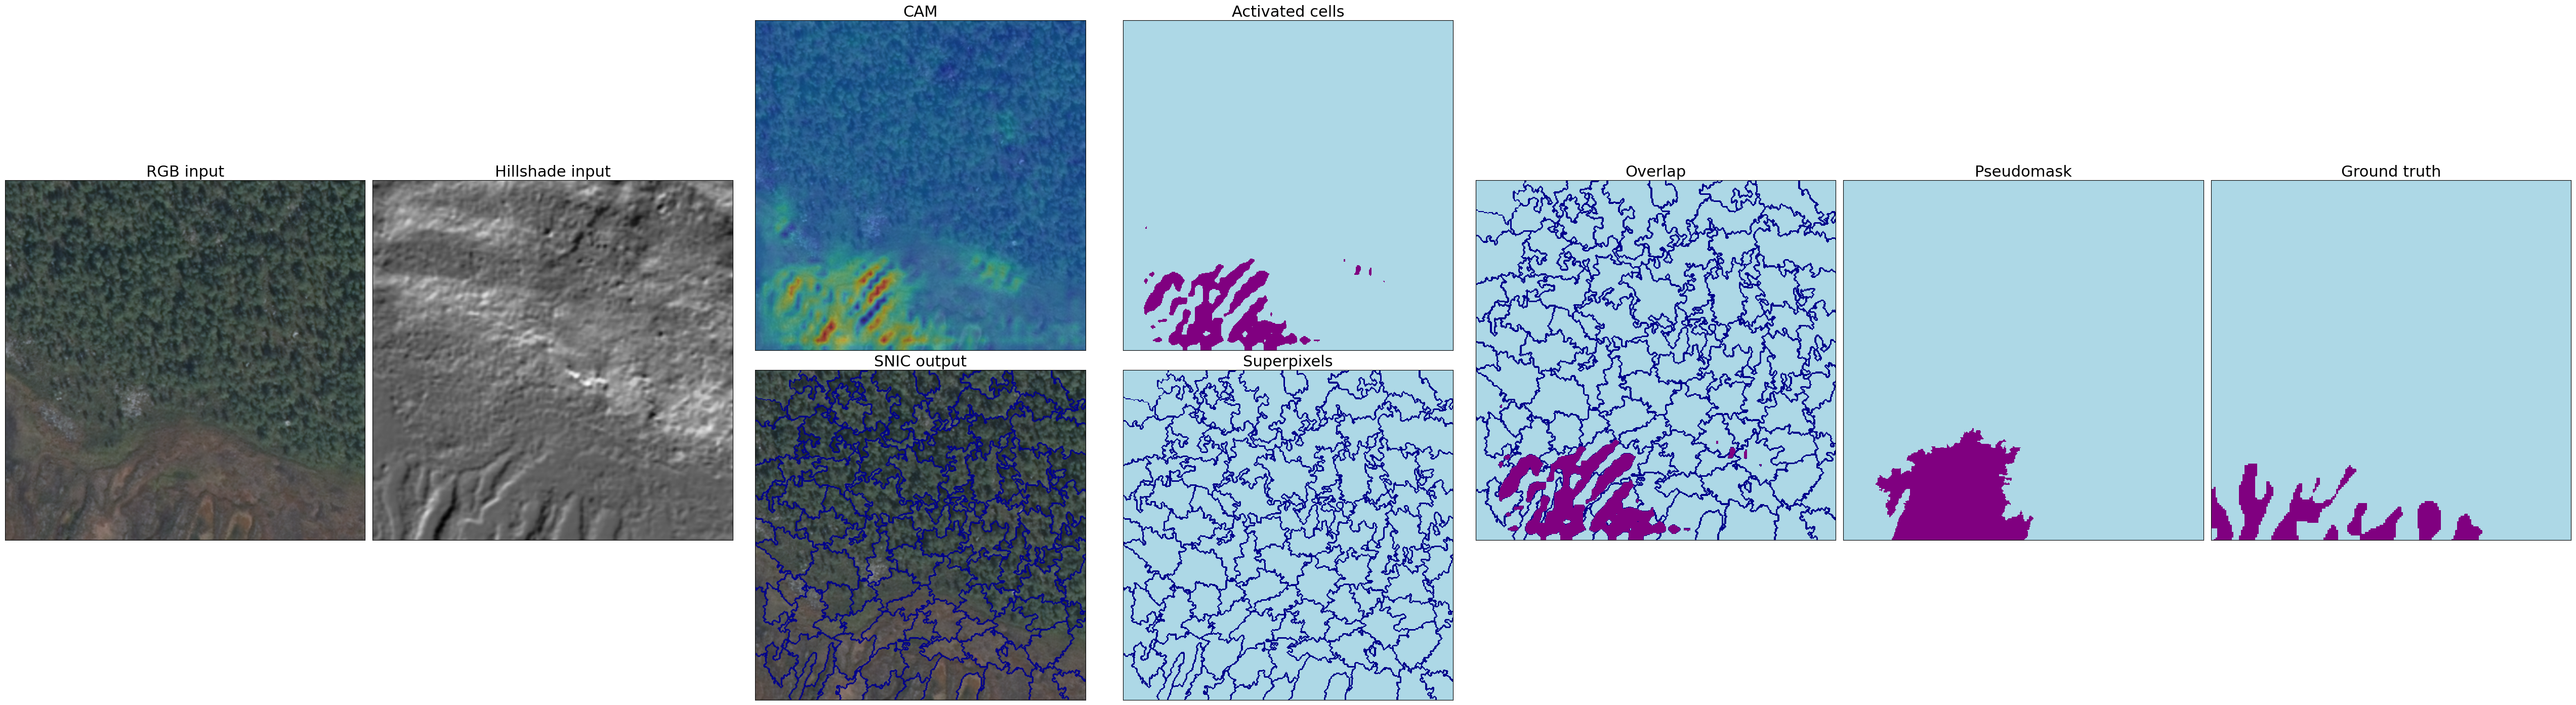

In [66]:
import matplotlib.pyplot as plt
import numpy as np

bounds = [0, 0.5, 1]
overlap_bounds = [0, 0.5, 4, 11]

cmap_cam = mcolors.ListedColormap(['lightblue', 'purple'])
norm_cam = mcolors.BoundaryNorm(bounds, cmap_cam.N)

cmap_snic = mcolors.ListedColormap(['lightblue', 'darkblue'])
norm_snic = mcolors.BoundaryNorm(bounds, cmap_snic.N)

cmap_overlap = mcolors.ListedColormap(['lightblue', 'darkblue', 'purple'])
norm_overlap = mcolors.BoundaryNorm(overlap_bounds, cmap_overlap.N)

# Create figure and gridspec
fig = plt.figure(figsize=(51, 14))  # Adjust figure size as needed
gs = fig.add_gridspec(2, 7)

# RGB input
ax0 = fig.add_subplot(gs[:, 0])
ax0.imshow(cpu_img[:,:,:3])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title(f'RGB input', size = 22)

# Hillshade input
ax1 = fig.add_subplot(gs[:, 1])
ax1.imshow(cpu_img[:,:,3], cmap = 'Greys')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(f'Hillshade input', size = 22)

# CAM
ax2a = fig.add_subplot(gs[0, 2])
ax2a.imshow(cpu_img[:,:,:3])
ax2a.imshow(pals_acts.view(im.shape[3], im.shape[3], 1), alpha=.4, cmap='jet')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_title(f'CAM', size = 22)

# Activation mask
ax2b = fig.add_subplot(gs[0, 3])
ax2b.imshow(pixels_activated, cmap=cmap_cam, norm=norm_cam)
ax2b.set_xticks([])
ax2b.set_yticks([])
ax2b.set_title(f'Activated cells', size = 22)

# Superpixels
boundaries = mark_boundaries(cpu_img[:,:,:3], superpixels)
binary_boundaries = np.where(boundaries[:,:,0]>0.5, 1, 0)
combined_image = np.copy(cpu_img[:,:,:3])
combined_image[binary_boundaries == 1] = [0,0,139]

# Superpixels on RGB
ax3a = fig.add_subplot(gs[1, 2])
ax3a.imshow(combined_image)
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_title(f'SNIC output', size = 22)

# Superpixel borders
ax3b = fig.add_subplot(gs[1, 3])
ax3b.imshow(binary_boundaries, cmap=cmap_snic, norm=norm_snic)
ax3b.set_xticks([])
ax3b.set_yticks([])
ax3b.set_title(f'Superpixels', size = 22)

# Overlap
overlap = np.copy(binary_boundaries)
overlap[np.squeeze(pixels_activated) == 1] = 10
ax4 = fig.add_subplot(gs[:, 4])
ax4.imshow(overlap, cmap=cmap_overlap, norm=norm_overlap)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title(f'Overlap', size = 22)

# Pseudomask
ax5 = fig.add_subplot(gs[:, 5])
ax5.imshow(pseudomask, cmap=cmap_cam, norm=norm_cam)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title(f'Pseudomask', size = 22)

# Ground truth
ax6 = fig.add_subplot(gs[:, 6])
ax6.imshow(gt.squeeze(0).permute(1,2,0).long().numpy(), cmap=cmap_cam, norm=norm_cam)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_title(f'Ground truth', size = 22)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [28]:
np.unique(overlap, return_counts=True)

(array([0, 1, 2]), array([131122,   4765,  24113]))

In [16]:
overlap_bounds = [0, 0.5, 1.5, 3]
cmap_overlap = mcolors.ListedColormap(['lightblue', 'purple', 'darkblue'])
norm_overlap = mcolors.BoundaryNorm(overlap_bounds, cmap_overlap.N)

# Overlap
overlap = np.copy(pixels_activated)
overlap[binary_boundaries == 1] = 2
plt.imshow(overlap, cmap=cmap_overlap, norm=norm_overlap)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

I think the issue is caused by boundary usually being 3 dims, dont exactly know what to change about that. 

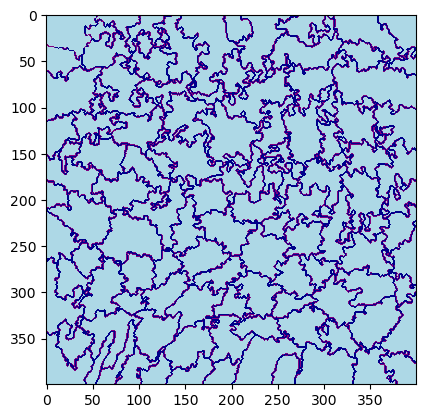

In [37]:
overlap_bounds = [0, 0.5, 1.5, 3]
cmap_overlap = mcolors.ListedColormap(['lightblue', 'purple', 'darkblue'])
norm_overlap = mcolors.BoundaryNorm(overlap_bounds, cmap_overlap.N)

copy = np.copy(binary_boundaries)
copy[copy == 1] = 2
plt.imshow(copy, cmap=cmap_overlap, norm=norm_overlap)

In [40]:
copy[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0,

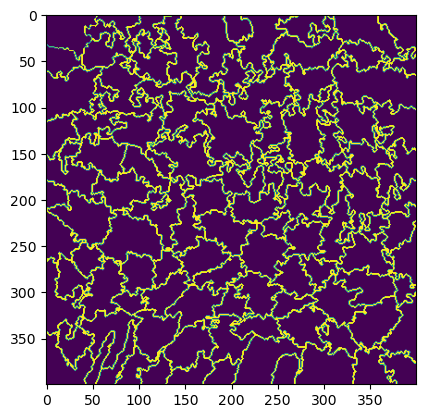

In [34]:
plt.imshow(binary_boundaries)

In [32]:
overlap_bounds = [0, 1.5, 4, 11]
cmap_overlap = mcolors.ListedColormap(['lightblue', 'purple', 'green'])
norm_overlap = mcolors.BoundaryNorm(overlap_bounds, cmap_overlap.N)

bin_copy = np.copy(binary_boundaries)
bin_copy[bin_copy == 1] = 2
bin_copy[np.squeeze(pixels_activated) == 1] = 10
plt.imshow(bin_copy, cmap=cmap_overlap, norm=norm_overlap)
# plt.imshow(bin_copy)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [28]:
np.unique(bin_copy, return_counts = True)

(array([0, 2]), array([132910,  27090]))